# Deep Data Exploration for Medical NER Fine-Tuning

This notebook performs comprehensive analysis of the medical NER dataset to inform fine-tuning decisions.

## Analysis Goals:
1. **Format Analysis**: Understand prompt/completion structures
2. **Entity Patterns**: Analyze chemical and disease naming patterns
3. **Relationship Patterns**: Study chemical-disease influence formats
4. **Data Distribution**: Optimal train/val/test splits
5. **Complexity Metrics**: Text length, entity counts, vocabulary
6. **Quality Assessment**: Identify potential issues or edge cases

## Key Questions:
- What are the most common entity patterns?
- Are there format inconsistencies to normalize?
- What's the optimal data split ratio?
- What vocabulary size should the model handle?
- Are there rare patterns that need attention?

## 1. Setup and Data Loading

In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter, defaultdict
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported")

✓ Libraries imported


In [6]:
# Load the full dataset
data_path = '/Users/alberto/projects/courses/building_llms/ch_10_fine_tuning/data/both_rel_instruct_all.jsonl'

with open(data_path, 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]

print(f"✓ Loaded {len(data):,} samples from {data_path}")
print(f"\nSample keys: {list(data[0].keys())}")

✓ Loaded 3,000 samples from /Users/alberto/projects/courses/building_llms/ch_10_fine_tuning/data/both_rel_instruct_all.jsonl

Sample keys: ['prompt', 'completion']


## 2. Task Distribution Analysis

Task Distribution:
Chemical Extraction           :  1000 (33.33%)
Disease Extraction            :  1000 (33.33%)
Relationship Extraction       :  1000 (33.33%)


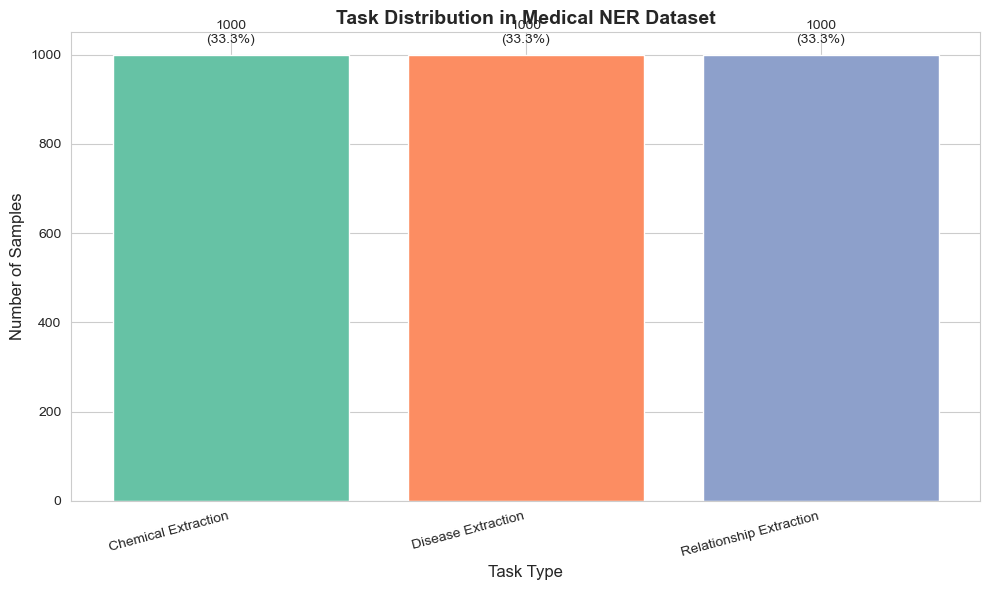


✓ Dataset is balanced across tasks


In [7]:
# Classify each sample by task type
def classify_task(sample):
    """Classify the task type based on prompt."""
    prompt = sample['prompt'].lower()
    
    # Check for relationship extraction first (most specific)
    if 'influences between' in prompt:
        return 'Relationship Extraction'
    elif 'chemicals mentioned' in prompt:
        return 'Chemical Extraction'
    elif 'diseases mentioned' in prompt:
        return 'Disease Extraction'
    else:
        return 'Other'

# Classify all samples
task_labels = [classify_task(sample) for sample in data]
task_counts = Counter(task_labels)

# Create DataFrame for analysis
df = pd.DataFrame(data)
df['task_type'] = task_labels

print("Task Distribution:")
print("="*50)
for task, count in task_counts.most_common():
    percentage = (count / len(data)) * 100
    print(f"{task:30s}: {count:5d} ({percentage:5.2f}%)")

# Visualize distribution
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('Set2', len(task_counts))
ax.bar(task_counts.keys(), task_counts.values(), color=colors)
ax.set_xlabel('Task Type', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Task Distribution in Medical NER Dataset', fontsize=14, fontweight='bold')
for i, (task, count) in enumerate(task_counts.items()):
    ax.text(i, count + 20, f'{count}\n({count/len(data)*100:.1f}%)', 
            ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print(f"\n✓ Dataset is {'balanced' if max(task_counts.values()) / min(task_counts.values()) < 1.5 else 'imbalanced'} across tasks")

## 3. Prompt Format Analysis

In [8]:
# Analyze prompt structure
print("="*80)
print("PROMPT FORMAT ANALYSIS")
print("="*80)

# Get examples of each task type
examples = {}
for task_type in task_counts.keys():
    examples[task_type] = df[df['task_type'] == task_type].iloc[0]

for task_type, example in examples.items():
    print(f"\n{'='*80}")
    print(f"Task: {task_type}")
    print(f"{'='*80}")
    
    # Show prompt structure
    prompt_lines = example['prompt'].split('\n')
    print(f"\nPrompt structure ({len(prompt_lines)} lines):")
    print(f"  First line: {prompt_lines[0][:100]}...")
    print(f"  Last line: {prompt_lines[-1][:100]}...")
    
    # Show full prompt (truncated)
    print(f"\nFull prompt (first 400 chars):")
    print(example['prompt'][:400] + "...\n")
    
    # Show completion
    print(f"Completion:")
    print(example['completion'])

PROMPT FORMAT ANALYSIS

Task: Chemical Extraction

Prompt structure (6 lines):
  First line: The following article contains technical terms including diseases, drugs and chemicals. Create a lis...
  Last line: ...

Full prompt (first 400 chars):
The following article contains technical terms including diseases, drugs and chemicals. Create a list only of the chemicals mentioned.

In unanesthetized, spontaneously hypertensive rats the decrease in blood pressure and heart rate produced by intravenous clonidine, 5 to 20 micrograms/kg, was inhibited or reversed by nalozone, 0.2 to 2 mg/kg. The hypotensive effect of 100 mg/kg alpha-methyldopa w...

Completion:
- clonidine
- nalozone
- alpha-methyldopa
- naloxone
- Naloxone
- [3H]-naloxone
- [3H]-dihydroergocryptine

Task: Disease Extraction

Prompt structure (6 lines):
  First line: The following article contains technical terms including diseases, drugs and chemicals. Create a lis...
  Last line: ...

Full prompt (first 400 chars):
The foll

Prompt Length Statistics:
       prompt_length  prompt_words
count    3000.000000   3000.000000
mean     1380.378667    198.040667
std       543.370343     81.236257
min       345.000000     45.000000
25%       937.750000    131.000000
50%      1357.000000    195.000000
75%      1769.000000    256.250000
max      4018.000000    553.000000


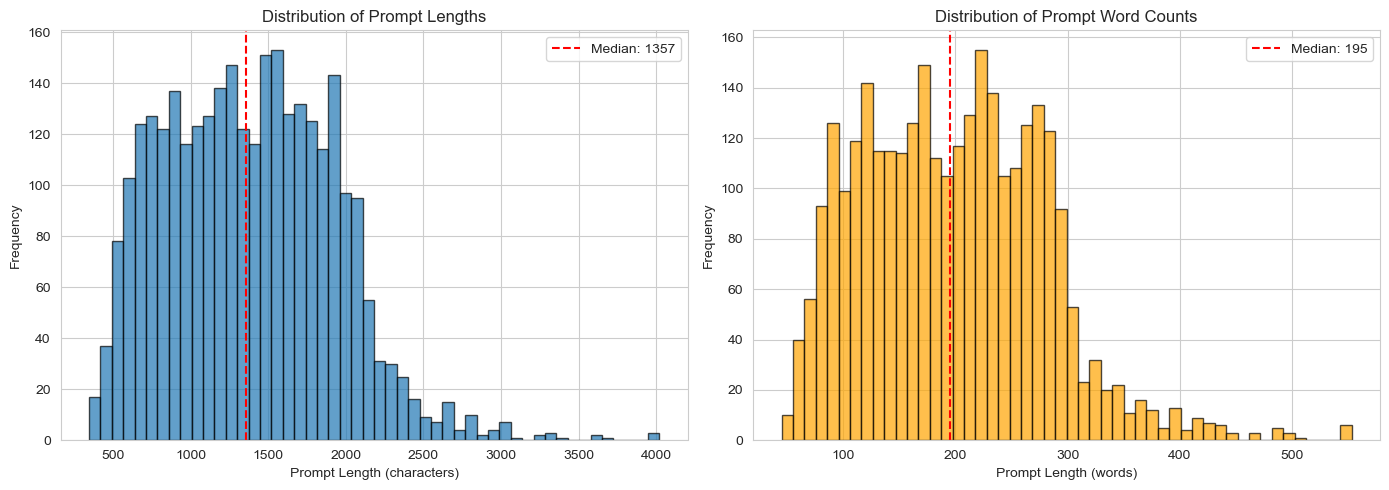


✓ Prompts range from 345 to 4018 characters
✓ Median prompt: 1357 chars, 195 words


In [9]:
# Analyze prompt lengths
df['prompt_length'] = df['prompt'].str.len()
df['prompt_words'] = df['prompt'].str.split().str.len()

print("Prompt Length Statistics:")
print("="*50)
print(df[['prompt_length', 'prompt_words']].describe())

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length
axes[0].hist(df['prompt_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df['prompt_length'].median(), color='red', linestyle='--', label=f'Median: {df["prompt_length"].median():.0f}')
axes[0].set_xlabel('Prompt Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prompt Lengths')
axes[0].legend()

# Word count
axes[1].hist(df['prompt_words'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(df['prompt_words'].median(), color='red', linestyle='--', label=f'Median: {df["prompt_words"].median():.0f}')
axes[1].set_xlabel('Prompt Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prompt Word Counts')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✓ Prompts range from {df['prompt_length'].min()} to {df['prompt_length'].max()} characters")
print(f"✓ Median prompt: {df['prompt_length'].median():.0f} chars, {df['prompt_words'].median():.0f} words")

## 4. Completion Format Analysis

Completion Statistics:
count    3000.000000
mean        3.584000
std         2.846573
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        21.000000
Name: num_items, dtype: float64


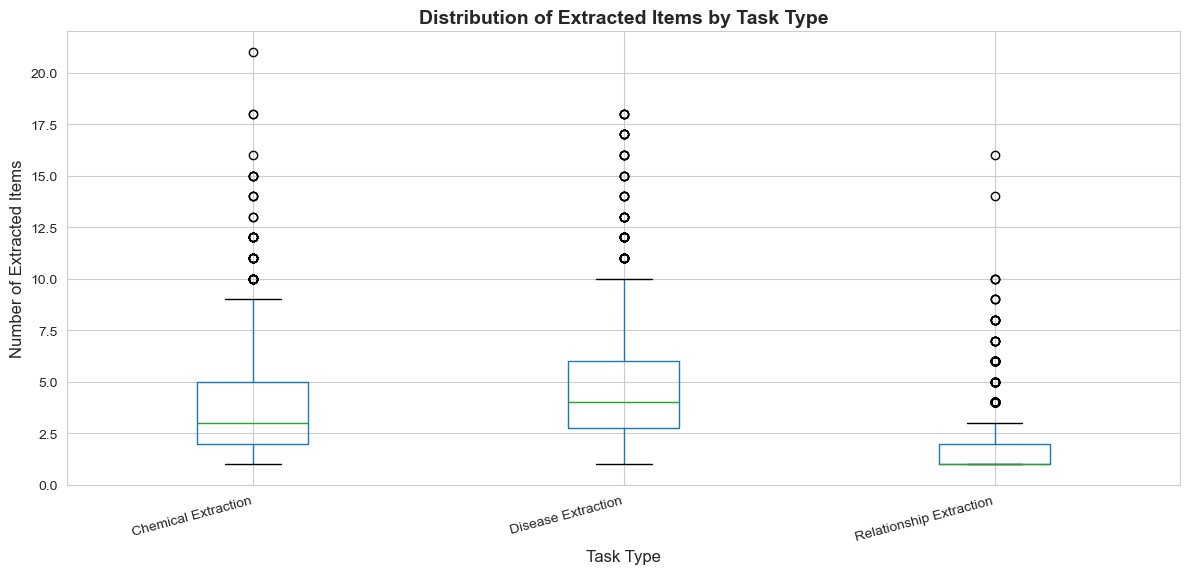


Items per task:
                          count   mean       std  min   25%  50%  75%   max
task_type                                                                  
Chemical Extraction      1000.0  3.897  2.790731  1.0  2.00  3.0  5.0  21.0
Disease Extraction       1000.0  4.805  3.153557  1.0  2.75  4.0  6.0  18.0
Relationship Extraction  1000.0  2.050  1.626698  1.0  1.00  1.0  2.0  16.0


In [10]:
# Parse completion items
def parse_completion(completion):
    """Extract bullet items from completion."""
    items = []
    for line in completion.split('\n'):
        match = re.match(r'^\s*[-*]\s*(.+?)\s*$', line)
        if match:
            items.append(match.group(1))
    return items

df['completion_items'] = df['completion'].apply(parse_completion)
df['num_items'] = df['completion_items'].apply(len)

print("Completion Statistics:")
print("="*50)
print(df['num_items'].describe())

# Plot item counts by task type
fig, ax = plt.subplots(figsize=(12, 6))
df.boxplot(column='num_items', by='task_type', ax=ax)
ax.set_xlabel('Task Type', fontsize=12)
ax.set_ylabel('Number of Extracted Items', fontsize=12)
ax.set_title('Distribution of Extracted Items by Task Type', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

# Show statistics per task
print("\nItems per task:")
print(df.groupby('task_type')['num_items'].describe())

In [11]:
# Analyze completion formats - detect OLD vs NEW format
print("\nCompletion Format Detection:")
print("="*50)

def detect_format(items, task_type):
    """Detect if items use OLD (sentence) or NEW (pipe) format."""
    if task_type != 'Relationship Extraction':
        return 'N/A'
    
    formats = []
    for item in items:
        if '|' in item:
            formats.append('NEW (pipe)')
        elif 'influences' in item.lower():
            formats.append('OLD (sentence)')
        else:
            formats.append('unknown')
    
    if not formats:
        return 'empty'
    
    # Return most common format
    return Counter(formats).most_common(1)[0][0]

df['completion_format'] = df.apply(lambda row: detect_format(row['completion_items'], row['task_type']), axis=1)

# Show format distribution for relationship extraction
rel_df = df[df['task_type'] == 'Relationship Extraction']
format_counts = rel_df['completion_format'].value_counts()

print("\nRelationship Extraction Format Analysis:")
for fmt, count in format_counts.items():
    print(f"  {fmt:20s}: {count:5d} ({count/len(rel_df)*100:5.2f}%)")

# Show examples of each format
print("\n" + "="*80)
print("FORMAT EXAMPLES")
print("="*80)

for fmt in ['OLD (sentence)', 'NEW (pipe)']:
    if fmt in format_counts:
        example = rel_df[rel_df['completion_format'] == fmt].iloc[0]
        print(f"\n{fmt} format:")
        print(f"{'─'*80}")
        for i, item in enumerate(example['completion_items'][:3], 1):
            print(f"  {i}. {item}")
        if len(example['completion_items']) > 3:
            print(f"  ... ({len(example['completion_items']) - 3} more items)")


Completion Format Detection:

Relationship Extraction Format Analysis:
  OLD (sentence)      :  1000 (100.00%)

FORMAT EXAMPLES

OLD (sentence) format:
────────────────────────────────────────────────────────────────────────────────
  1. Chemical alpha-methyldopa influences disease hypotensive


## 5. Entity Pattern Analysis

In [12]:
# Extract all entities by type
chemicals = []
diseases = []
influences = []

for _, row in df.iterrows():
    if row['task_type'] == 'Chemical Extraction':
        chemicals.extend(row['completion_items'])
    elif row['task_type'] == 'Disease Extraction':
        diseases.extend(row['completion_items'])
    elif row['task_type'] == 'Relationship Extraction':
        influences.extend(row['completion_items'])

print("Entity Counts:")
print("="*50)
print(f"  Total chemicals: {len(chemicals):,}")
print(f"  Total diseases: {len(diseases):,}")
print(f"  Total influences: {len(influences):,}")
print(f"\n  Unique chemicals: {len(set([c.lower() for c in chemicals])):,}")
print(f"  Unique diseases: {len(set([d.lower() for d in diseases])):,}")

Entity Counts:
  Total chemicals: 3,897
  Total diseases: 4,805
  Total influences: 2,050

  Unique chemicals: 1,578
  Unique diseases: 2,199


In [13]:
# Most common entities
chem_counter = Counter([c.lower() for c in chemicals])
disease_counter = Counter([d.lower() for d in diseases])

print("\nTop 20 Most Common Chemicals:")
print("="*50)
for i, (chem, count) in enumerate(chem_counter.most_common(20), 1):
    print(f"  {i:2d}. {chem:40s} ({count:3d} occurrences)")

print("\n\nTop 20 Most Common Diseases:")
print("="*50)
for i, (disease, count) in enumerate(disease_counter.most_common(20), 1):
    print(f"  {i:2d}. {disease:40s} ({count:3d} occurrences)")


Top 20 Most Common Chemicals:
   1. dopamine                                 ( 51 occurrences)
   2. cocaine                                  ( 35 occurrences)
   3. haloperidol                              ( 33 occurrences)
   4. creatinine                               ( 32 occurrences)
   5. calcium                                  ( 30 occurrences)
   6. potassium                                ( 26 occurrences)
   7. morphine                                 ( 25 occurrences)
   8. lithium                                  ( 24 occurrences)
   9. serotonin                                ( 24 occurrences)
  10. doxorubicin                              ( 24 occurrences)
  11. cyclophosphamide                         ( 23 occurrences)
  12. oxygen                                   ( 23 occurrences)
  13. levodopa                                 ( 22 occurrences)
  14. amphetamine                              ( 21 occurrences)
  15. tacrolimus                               ( 20 occurre

In [14]:
# Analyze entity name patterns
def analyze_naming_patterns(entities, entity_type):
    """Analyze patterns in entity naming."""
    patterns = {
        'single_word': 0,
        'multi_word': 0,
        'hyphenated': 0,
        'with_numbers': 0,
        'with_parentheses': 0,
        'with_special_chars': 0,
    }
    
    lengths = []
    word_counts = []
    
    for entity in entities:
        entity = entity.strip()
        lengths.append(len(entity))
        words = entity.split()
        word_counts.append(len(words))
        
        if len(words) == 1:
            patterns['single_word'] += 1
        else:
            patterns['multi_word'] += 1
        
        if '-' in entity:
            patterns['hyphenated'] += 1
        if re.search(r'\d', entity):
            patterns['with_numbers'] += 1
        if '(' in entity or ')' in entity:
            patterns['with_parentheses'] += 1
        if re.search(r'[^a-zA-Z0-9\s\-()]', entity):
            patterns['with_special_chars'] += 1
    
    print(f"\n{entity_type} Naming Patterns:")
    print("="*50)
    total = len(entities)
    for pattern, count in patterns.items():
        print(f"  {pattern:25s}: {count:5d} ({count/total*100:5.2f}%)")
    
    print(f"\n  Avg length: {np.mean(lengths):.1f} chars")
    print(f"  Avg word count: {np.mean(word_counts):.2f} words")
    print(f"  Max word count: {max(word_counts)} words")
    
    return patterns, lengths, word_counts

chem_patterns, chem_lengths, chem_words = analyze_naming_patterns(chemicals, "Chemical")
disease_patterns, disease_lengths, disease_words = analyze_naming_patterns(diseases, "Disease")


Chemical Naming Patterns:
  single_word              :  3407 (87.43%)
  multi_word               :   490 (12.57%)
  hyphenated               :   359 ( 9.21%)
  with_numbers             :   309 ( 7.93%)
  with_parentheses         :    40 ( 1.03%)
  with_special_chars       :    70 ( 1.80%)

  Avg length: 11.1 chars
  Avg word count: 1.16 words
  Max word count: 15 words

Disease Naming Patterns:
  single_word              :  2535 (52.76%)
  multi_word               :  2270 (47.24%)
  hyphenated               :   100 ( 2.08%)
  with_numbers             :     5 ( 0.10%)
  with_parentheses         :    23 ( 0.48%)
  with_special_chars       :    85 ( 1.77%)

  Avg length: 14.9 chars
  Avg word count: 1.71 words
  Max word count: 15 words


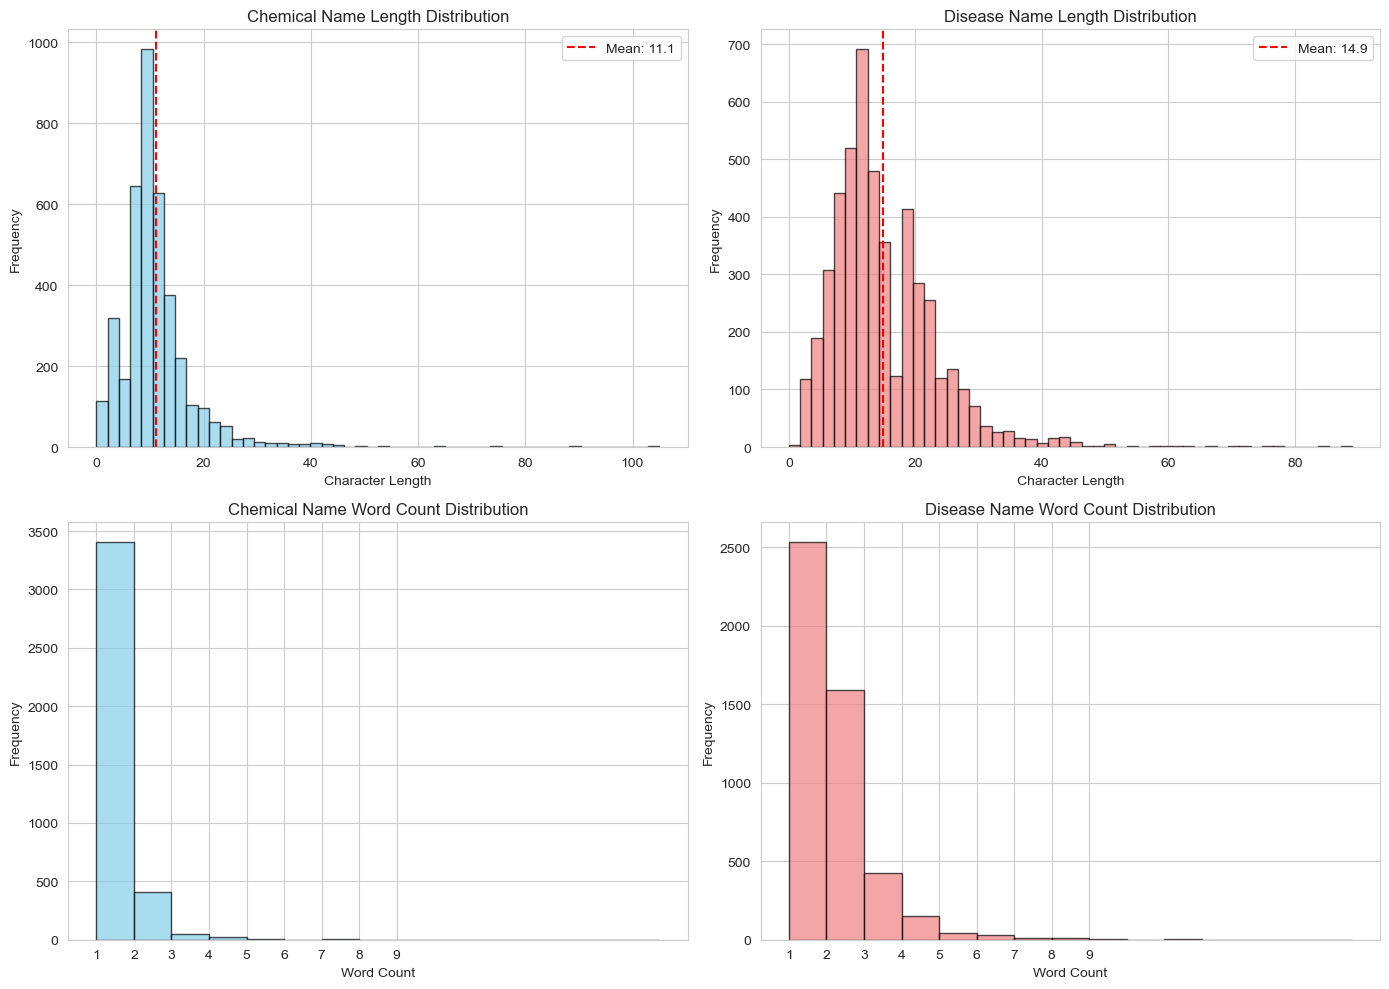

In [15]:
# Visualize entity characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chemical length distribution
axes[0, 0].hist(chem_lengths, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(np.mean(chem_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(chem_lengths):.1f}')
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Chemical Name Length Distribution')
axes[0, 0].legend()

# Disease length distribution
axes[0, 1].hist(disease_lengths, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].axvline(np.mean(disease_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(disease_lengths):.1f}')
axes[0, 1].set_xlabel('Character Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Disease Name Length Distribution')
axes[0, 1].legend()

# Chemical word count
axes[1, 0].hist(chem_words, bins=range(1, max(chem_words)+2), edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Chemical Name Word Count Distribution')
axes[1, 0].set_xticks(range(1, min(max(chem_words)+1, 10)))

# Disease word count
axes[1, 1].hist(disease_words, bins=range(1, max(disease_words)+2), edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Disease Name Word Count Distribution')
axes[1, 1].set_xticks(range(1, min(max(disease_words)+1, 10)))

plt.tight_layout()
plt.show()

## 6. Relationship Pattern Analysis

In [16]:
# Parse relationships from both formats
def parse_relationship(item):
    """Extract chemical and disease from relationship item."""
    # NEW format: "chemical | disease"
    if '|' in item:
        parts = item.split('|')
        if len(parts) == 2:
            return parts[0].strip(), parts[1].strip(), 'pipe'
    
    # OLD format: "chemical X influences disease Y"
    match = re.match(r'^\s*chemical\s+(.+?)\s+influences\s+disease\s+(.+?)\s*$', item, re.I)
    if match:
        return match.group(1).strip(), match.group(2).strip(), 'sentence'
    
    return None, None, 'unknown'

# Parse all relationships
relationships = []
for influence in influences:
    chem, disease, fmt = parse_relationship(influence)
    if chem and disease:
        relationships.append({
            'chemical': chem.lower(),
            'disease': disease.lower(),
            'format': fmt,
            'raw': influence
        })

rel_df_analysis = pd.DataFrame(relationships)

print(f"Parsed Relationships: {len(rel_df_analysis):,}")
print(f"\nFormat distribution:")
print(rel_df_analysis['format'].value_counts())

print(f"\n\nMost Common Chemical-Disease Pairs:")
print("="*80)
pair_counts = Counter([(r['chemical'], r['disease']) for r in relationships])
for i, ((chem, disease), count) in enumerate(pair_counts.most_common(15), 1):
    print(f"  {i:2d}. {chem:30s} → {disease:35s} ({count:2d}x)")

Parsed Relationships: 2,050

Format distribution:
format
sentence    2050
Name: count, dtype: int64


Most Common Chemical-Disease Pairs:
   1. levodopa                       → dyskinesias                         (12x)
   2. haloperidol                    → catalepsy                           (11x)
   3. scopolamine                    → amnesia                             ( 8x)
   4. pilocarpine                    → status epilepticus                  ( 7x)
   5. puromycin aminonucleoside      → proteinuria                         ( 6x)
   6. cyclophosphamide               → cystitis                            ( 6x)
   7. isoproterenol                  → myocardial infarction               ( 6x)
   8. cocaine                        → seizures                            ( 6x)
   9. doxorubicin                    → cardiomyopathy                      ( 6x)
  10. heparin                        → thrombocytopenia                    ( 5x)
  11. pilocarpine                    → seizures     

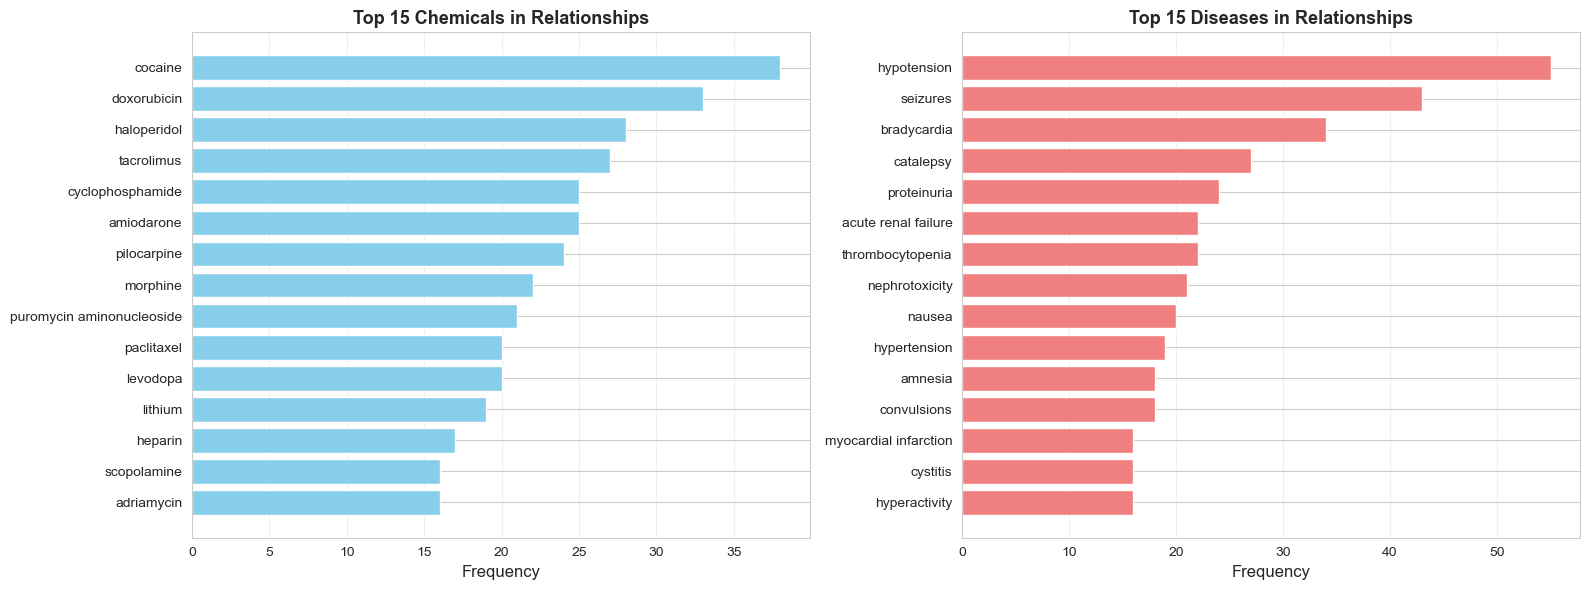


✓ 625 unique chemicals in relationships
✓ 845 unique diseases in relationships


In [17]:
# Analyze chemical and disease frequencies in relationships
rel_chemicals = Counter([r['chemical'] for r in relationships])
rel_diseases = Counter([r['disease'] for r in relationships])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top chemicals in relationships
top_chem = rel_chemicals.most_common(15)
axes[0].barh([c[0] for c in top_chem][::-1], [c[1] for c in top_chem][::-1], color='skyblue')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 15 Chemicals in Relationships', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Top diseases in relationships
top_dis = rel_diseases.most_common(15)
axes[1].barh([d[0] for d in top_dis][::-1], [d[1] for d in top_dis][::-1], color='lightcoral')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_title('Top 15 Diseases in Relationships', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ {len(rel_chemicals)} unique chemicals in relationships")
print(f"✓ {len(rel_diseases)} unique diseases in relationships")

## 7. Data Quality Assessment

In [18]:
# Check for potential issues
print("Data Quality Checks:")
print("="*80)

# 1. Empty completions
empty_completions = df[df['num_items'] == 0]
print(f"\n1. Empty completions: {len(empty_completions)} ({len(empty_completions)/len(df)*100:.2f}%)")
if len(empty_completions) > 0:
    print(f"   Task distribution:")
    print(empty_completions['task_type'].value_counts())

# 2. Very short prompts (potentially incomplete)
short_prompts = df[df['prompt_length'] < 100]
print(f"\n2. Very short prompts (<100 chars): {len(short_prompts)} ({len(short_prompts)/len(df)*100:.2f}%)")

# 3. Very long prompts (potential truncation issues)
long_prompts = df[df['prompt_length'] > 2000]
print(f"\n3. Very long prompts (>2000 chars): {len(long_prompts)} ({len(long_prompts)/len(df)*100:.2f}%)")
if len(long_prompts) > 0:
    print(f"   Max length: {long_prompts['prompt_length'].max()} chars")
    print(f"   Recommended max_length for tokenization: {int(long_prompts['prompt_length'].max() * 1.3)}")

# 4. Duplicate prompts
duplicate_prompts = df[df.duplicated(subset='prompt', keep=False)]
print(f"\n4. Duplicate prompts: {len(duplicate_prompts)} ({len(duplicate_prompts)/len(df)*100:.2f}%)")

# 5. Format inconsistencies in relationships
if 'completion_format' in df.columns:
    unknown_format = df[df['completion_format'] == 'unknown']
    print(f"\n5. Unknown format relationships: {len(unknown_format)} ({len(unknown_format)/len(df)*100:.2f}%)")

Data Quality Checks:

1. Empty completions: 0 (0.00%)

2. Very short prompts (<100 chars): 0 (0.00%)

3. Very long prompts (>2000 chars): 369 (12.30%)
   Max length: 4018 chars
   Recommended max_length for tokenization: 5223

4. Duplicate prompts: 0 (0.00%)

5. Unknown format relationships: 0 (0.00%)


In [19]:
# Check for special characters that might need normalization
def find_special_chars(text_list):
    """Find all special characters in text."""
    all_chars = set()
    for text in text_list:
        all_chars.update(set(text))
    
    # Filter to non-alphanumeric
    special = {c for c in all_chars if not c.isalnum() and not c.isspace()}
    return sorted(special)

all_entities = chemicals + diseases
special_chars = find_special_chars(all_entities)

print("\nSpecial Characters in Entities:")
print("="*50)
print(f"Found {len(special_chars)} unique special characters:")
print(f"  {', '.join(repr(c) for c in special_chars)}")

# Show examples with each special char
print("\nExamples:")
for char in special_chars[:5]:  # Show first 5
    examples = [e for e in all_entities if char in e][:3]
    print(f"  {repr(char)}: {', '.join(examples)}")


Special Characters in Entities:
Found 13 unique special characters:
  '%', "'", '(', ')', '+', ',', '-', '.', '/', ':', '<', '[', ']'

Examples:
  '%': Renografin 76%, Hypaque 76%
  "'": alpha,beta-methylene adenosine-5'-triphosphate, N, N'-diisopropylphosphorodiamidofluoridate, 4'-0-tetrahydropyranyladriamycin
  '(': N-[4-(5-nitro-2-furyl)-2-thiazolyl]-formamide, 3alpha-tropyl 2-(p-bromophenyl)propionate, S-(-)-ET-126
  ')': N-[4-(5-nitro-2-furyl)-2-thiazolyl]-formamide, 3alpha-tropyl 2-(p-bromophenyl)propionate, S-(-)-ET-126
  '+': [-]-[5aR,11bS]-4,5,5a,6,7,11b-hexahydro-2-propyl-3-thia-5-+ ++azacyclopent-1- ena[c]phenathrene-9-10-diol


## 8. Optimal Split Recommendations

In [20]:
# Calculate recommended split sizes
total_samples = len(df)

print("="*80)
print("TRAIN/VALIDATION/TEST SPLIT RECOMMENDATIONS")
print("="*80)

# Different split strategies
strategies = [
    ("80/10/10", 0.80, 0.10, 0.10),
    ("70/15/15", 0.70, 0.15, 0.15),
    ("85/10/5", 0.85, 0.10, 0.05),
    ("90/5/5", 0.90, 0.05, 0.05),
]

for name, train_pct, val_pct, test_pct in strategies:
    train_size = int(total_samples * train_pct)
    val_size = int(total_samples * val_pct)
    test_size = total_samples - train_size - val_size
    
    print(f"\n{name} Split:")
    print(f"  Train: {train_size:4d} samples ({train_size/total_samples*100:.1f}%)")
    print(f"  Val:   {val_size:4d} samples ({val_size/total_samples*100:.1f}%)")
    print(f"  Test:  {test_size:4d} samples ({test_size/total_samples*100:.1f}%)")
    
    # Check if validation set is large enough for reliable metrics
    if val_size < 100:
        print(f"  ⚠️  Validation set may be too small (<100 samples)")
    if test_size < 100:
        print(f"  ⚠️  Test set may be too small (<100 samples)")

print(f"\n{'='*80}")
print("RECOMMENDATION:")
print(f"{'='*80}")
print(f"✓ Use 80/10/10 split (current approach)")
print(f"✓ Train: ~{int(total_samples * 0.8)} samples (sufficient for fine-tuning)")
print(f"✓ Val:   ~{int(total_samples * 0.1)} samples (reliable for early stopping)")
print(f"✓ Test:  ~{int(total_samples * 0.1)} samples (statistically significant)")
print(f"\n✓ CRITICAL: Use stratified splitting to maintain task balance!")
print(f"✓ CRITICAL: Deduplicate before splitting to prevent leakage!")

TRAIN/VALIDATION/TEST SPLIT RECOMMENDATIONS

80/10/10 Split:
  Train: 2400 samples (80.0%)
  Val:    300 samples (10.0%)
  Test:   300 samples (10.0%)

70/15/15 Split:
  Train: 2100 samples (70.0%)
  Val:    450 samples (15.0%)
  Test:   450 samples (15.0%)

85/10/5 Split:
  Train: 2550 samples (85.0%)
  Val:    300 samples (10.0%)
  Test:   150 samples (5.0%)

90/5/5 Split:
  Train: 2700 samples (90.0%)
  Val:    150 samples (5.0%)
  Test:   150 samples (5.0%)

RECOMMENDATION:
✓ Use 80/10/10 split (current approach)
✓ Train: ~2400 samples (sufficient for fine-tuning)
✓ Val:   ~300 samples (reliable for early stopping)
✓ Test:  ~300 samples (statistically significant)

✓ CRITICAL: Use stratified splitting to maintain task balance!
✓ CRITICAL: Deduplicate before splitting to prevent leakage!


## 9. Vocabulary Analysis

In [21]:
# Build vocabulary from all text
from collections import defaultdict

def tokenize_simple(text):
    """Simple word tokenization."""
    # Keep hyphens in words like "type-2"
    words = re.findall(r'\b[\w-]+\b', text.lower())
    return words

# Collect all words from prompts and completions
all_words = []
for _, row in df.iterrows():
    all_words.extend(tokenize_simple(row['prompt']))
    all_words.extend(tokenize_simple(row['completion']))

vocab = Counter(all_words)

print("Vocabulary Statistics:")
print("="*50)
print(f"Total words: {len(all_words):,}")
print(f"Unique words: {len(vocab):,}")
print(f"Vocabulary size (>1 occurrence): {len([w for w, c in vocab.items() if c > 1]):,}")
print(f"Rare words (1 occurrence): {len([w for w, c in vocab.items() if c == 1]):,}")

# Most common words
print(f"\nTop 30 Most Common Words:")
print("="*50)
for i, (word, count) in enumerate(vocab.most_common(30), 1):
    print(f"  {i:2d}. {word:25s} ({count:5d} occurrences)")

Vocabulary Statistics:
Total words: 630,534
Unique words: 13,710
Vocabulary size (>1 occurrence): 13,678
Rare words (1 occurrence): 32

Top 30 Most Common Words:
   1. the                       (31444 occurrences)
   2. of                        (29319 occurrences)
   3. and                       (21128 occurrences)
   4. in                        (15605 occurrences)
   5. a                         (11745 occurrences)
   6. to                        ( 9211 occurrences)
   7. with                      ( 7741 occurrences)
   8. was                       ( 6163 occurrences)
   9. diseases                  ( 6058 occurrences)
  10. list                      ( 6021 occurrences)
  11. chemicals                 ( 6000 occurrences)
  12. were                      ( 4779 occurrences)
  13. patients                  ( 4464 occurrences)
  14. influences                ( 4062 occurrences)
  15. for                       ( 3879 occurrences)
  16. only                      ( 3564 occurrences)
  17. 

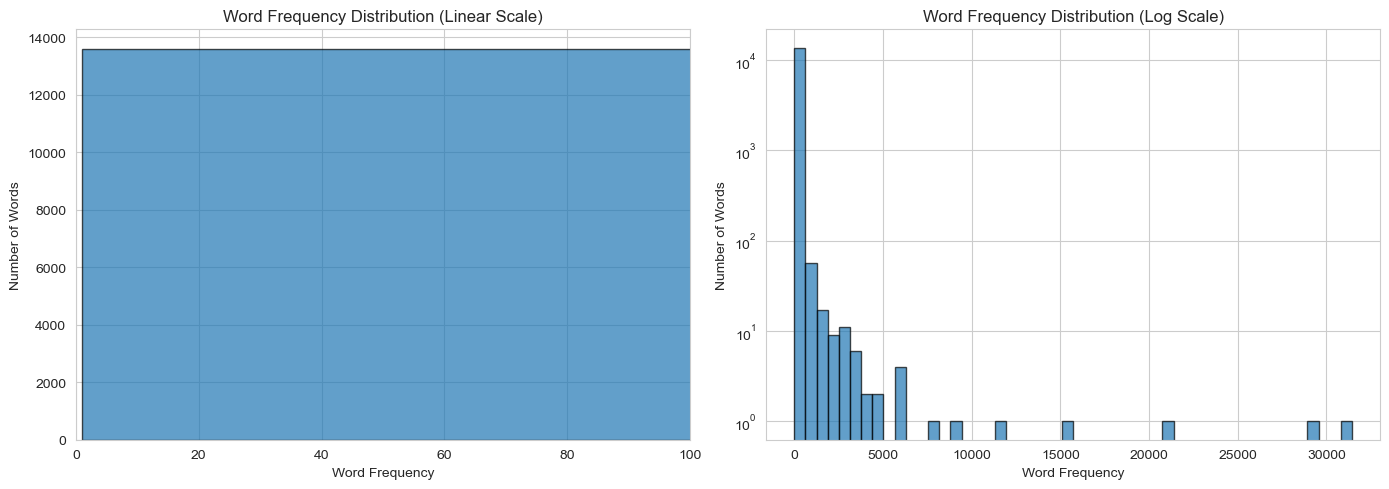


✓ Typical Zipf's law distribution observed
✓ Most words are rare (long tail)


In [22]:
# Frequency distribution
frequencies = list(vocab.values())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Word Frequency')
axes[0].set_ylabel('Number of Words')
axes[0].set_title('Word Frequency Distribution (Linear Scale)')
axes[0].set_xlim(0, 100)

# Log scale
axes[1].hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Word Frequency')
axes[1].set_ylabel('Number of Words')
axes[1].set_title('Word Frequency Distribution (Log Scale)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ Typical Zipf's law distribution observed")
print(f"✓ Most words are rare (long tail)")

## 10. Key Findings & Recommendations Summary

In [23]:
# Generate comprehensive summary
print("="*80)
print("DEEP DATA EXPLORATION SUMMARY")
print("="*80)

print("\n1. DATASET OVERVIEW")
print("   " + "─"*76)
print(f"   • Total samples: {len(df):,}")
print(f"   • Task distribution: {dict(task_counts)}")
print(f"   • Balance: {'✓ Well-balanced' if max(task_counts.values())/min(task_counts.values()) < 1.5 else '⚠️ Imbalanced'}")

print("\n2. PROMPT CHARACTERISTICS")
print("   " + "─"*76)
print(f"   • Median length: {df['prompt_length'].median():.0f} characters")
print(f"   • Median words: {df['prompt_words'].median():.0f} words")
print(f"   • Range: {df['prompt_length'].min()}-{df['prompt_length'].max()} characters")
print(f"   • Recommended max_length: 2048 tokens")

print("\n3. COMPLETION PATTERNS")
print("   " + "─"*76)
print(f"   • Median items per sample: {df['num_items'].median():.0f}")
print(f"   • Total unique chemicals: {len(set([c.lower() for c in chemicals])):,}")
print(f"   • Total unique diseases: {len(set([d.lower() for d in diseases])):,}")
print(f"   • Relationship format: {rel_df_analysis['format'].value_counts().to_dict() if len(rel_df_analysis) > 0 else 'N/A'}")

print("\n4. ENTITY NAMING PATTERNS")
print("   " + "─"*76)
print(f"   • Avg chemical name: {np.mean(chem_lengths):.1f} chars, {np.mean(chem_words):.1f} words")
print(f"   • Avg disease name: {np.mean(disease_lengths):.1f} chars, {np.mean(disease_words):.1f} words")
print(f"   • Hyphenated entities: ~{chem_patterns['hyphenated']+disease_patterns['hyphenated']:,}")
print(f"   • Special characters found: {len(special_chars)}")

print("\n5. DATA QUALITY")
print("   " + "─"*76)
print(f"   • Empty completions: {len(empty_completions)} ({len(empty_completions)/len(df)*100:.2f}%)")
print(f"   • Duplicate prompts: {len(duplicate_prompts)} ({len(duplicate_prompts)/len(df)*100:.2f}%)")
print(f"   • Quality score: {'✓ High' if len(empty_completions) < 10 and len(duplicate_prompts)/len(df) < 0.05 else '⚠️ Needs attention'}")

print("\n6. VOCABULARY")
print("   " + "─"*76)
print(f"   • Total vocabulary: {len(vocab):,} unique words")
print(f"   • Active vocabulary (>1 occurrence): {len([w for w, c in vocab.items() if c > 1]):,}")
print(f"   • Rare words: {len([w for w, c in vocab.items() if c == 1]):,} (singleton)")

print("\n" + "="*80)
print("KEY RECOMMENDATIONS FOR FINE-TUNING")
print("="*80)

print("\n✓ DATA SPLIT")
print("  • Use 80/10/10 train/val/test split")
print("  • CRITICAL: Apply stratified splitting (maintain task distribution)")
print("  • CRITICAL: Deduplicate prompts before splitting")
print("  • Expected sizes: ~{:,} train, ~{:,} val, ~{:,} test".format(
    int(len(df)*0.8), int(len(df)*0.1), int(len(df)*0.1)
))

print("\n✓ FORMAT STANDARDIZATION")
if 'completion_format' in df.columns:
    old_format_count = len(df[df['completion_format'] == 'OLD (sentence)'])
    if old_format_count > 0:
        print("  • ⚠️ CONVERT relationships from OLD to NEW format during preprocessing")
        print("    OLD: 'chemical X influences disease Y'")
        print("    NEW: 'X | Y'")
    else:
        print("  • ✓ Format already standardized")
print("  • Preserve hyphens in entity names (e.g., 'type-2 diabetes')")
print("  • System prompt should specify: '- chemical | disease' format")

print("\n✓ TOKENIZATION")
print("  • Recommended max_length: 2048 tokens")
print("  • Padding side: right")
print("  • Truncation: enabled")

print("\n✓ TRAINING PARAMETERS")
print("  • Batch size: 4-8 per device")
print("  • Gradient accumulation: 4 (effective batch = 16-32)")
print("  • Learning rate: 5e-5 (conservative for LoRA)")
print("  • Epochs: 5 (sufficient for format learning)")
print("  • Scheduler: cosine decay with warmup")

print("\n✓ EVALUATION STRATEGY")
print("  • Metric: F1 score per task type")
print("  • Normalize entities before comparison (lowercase, trim)")
print("  • Use word boundaries for matching (prevent substring false positives)")
print("  • Track chemical F1, disease F1, influence F1 separately")

print("\n" + "="*80)
print("✅ Analysis complete! Ready for fine-tuning.")
print("="*80)

DEEP DATA EXPLORATION SUMMARY

1. DATASET OVERVIEW
   ────────────────────────────────────────────────────────────────────────────
   • Total samples: 3,000
   • Task distribution: {'Chemical Extraction': 1000, 'Disease Extraction': 1000, 'Relationship Extraction': 1000}
   • Balance: ✓ Well-balanced

2. PROMPT CHARACTERISTICS
   ────────────────────────────────────────────────────────────────────────────
   • Median length: 1357 characters
   • Median words: 195 words
   • Range: 345-4018 characters
   • Recommended max_length: 2048 tokens

3. COMPLETION PATTERNS
   ────────────────────────────────────────────────────────────────────────────
   • Median items per sample: 3
   • Total unique chemicals: 1,578
   • Total unique diseases: 2,199
   • Relationship format: {'sentence': 2050}

4. ENTITY NAMING PATTERNS
   ────────────────────────────────────────────────────────────────────────────
   • Avg chemical name: 11.1 chars, 1.2 words
   • Avg disease name: 14.9 chars, 1.7 words
   • 

## 11. Export Analysis Results

In [24]:
# Save analysis results
output_dir = Path('../docs')
output_dir.mkdir(exist_ok=True)

# Export summary statistics
summary_stats = {
    'total_samples': len(df),
    'task_distribution': dict(task_counts),
    'prompt_median_length': float(df['prompt_length'].median()),
    'prompt_median_words': float(df['prompt_words'].median()),
    'unique_chemicals': len(set([c.lower() for c in chemicals])),
    'unique_diseases': len(set([d.lower() for d in diseases])),
    'vocabulary_size': len(vocab),
    'duplicate_prompts': len(duplicate_prompts),
    'empty_completions': len(empty_completions),
    'recommended_split': '80/10/10',
    'recommended_max_length': 2048,
}

with open(output_dir / 'data_exploration_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"✓ Summary statistics saved to: {output_dir / 'data_exploration_summary.json'}")

# Export top entities
entity_lists = {
    'top_chemicals': [{'name': c, 'count': count} for c, count in chem_counter.most_common(50)],
    'top_diseases': [{'name': d, 'count': count} for d, count in disease_counter.most_common(50)],
    'top_chemical_disease_pairs': [
        {'chemical': c, 'disease': d, 'count': count} 
        for (c, d), count in pair_counts.most_common(50)
    ]
}

with open(output_dir / 'top_entities.json', 'w') as f:
    json.dump(entity_lists, f, indent=2)

print(f"✓ Top entities saved to: {output_dir / 'top_entities.json'}")

print("\n✅ All analysis results exported!")

✓ Summary statistics saved to: ../docs/data_exploration_summary.json
✓ Top entities saved to: ../docs/top_entities.json

✅ All analysis results exported!
